# APS360 Group Project

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from train import train_net, train_auto_encoder, init_device, test_net
from graph import plot_training_curve, generate_confusion_matrix, visualize_output, visualize_autoencoder_output

In [2]:
init_device()

Cuda Available: True


## Baseline Model

In [3]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


In [4]:
train_net(BaselineModel, "baseline_model", learning_rate=0.005, num_epochs=20)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.7015, Train loss: 1.600324846328573 | Validation err: 1.0, Validation loss: 8.694899559020996
Epoch 2: Train err: 0.5138333333333334, Train loss: 1.0861271036432145 | Validation err: 1.0, Validation loss: 14.071547269821167
Epoch 3: Train err: 0.348, Train loss: 0.7778826102297357 | Validation err: 1.0, Validation loss: 18.38157296180725
Epoch 4: Train err: 0.18866666666666668, Train loss: 0.48375745085959737 | Validation err: 1.0, Validation loss: 26.98893165588379
Epoch 5: Train err: 0.067, Train loss: 0.20450881503997964 | Validation err: 1.0, Validation loss: 42.67613220214844
Epoch 6: Train err: 0.0455, Train loss: 0.145998773898216 | Validation err: 1.0, Validation loss: 42.64294934272766
Epoch 7: Train err: 0.031166666666666665, Train loss: 0.10667097172204484 | Validation err: 1.0, Validation loss: 50.297051668167114
Epoch 8: Train err: 0.021833333333333333, Train loss: 0.08328509489272504 | Validation err: 1.0, Validati

## Primary Model

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))    # 32 x 112 x 112
        x = self.bn2(F.relu(self.conv2(x)))    # 64 x 56 x 56
        x = self.bn3(F.relu(self.conv3(x)))    # 128 x 28 x 28

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x):

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)) )
        x = self.conv6(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

class PrimaryModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(128, 64, 1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128,32,1)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(16*2*28*28, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = torch.cat((x1,x2), dim=1)
        x = self.bn5(F.relu(self.conv5(x)))
                
        x = x.view(-1, 16*2*28*28)
        x = self.bn6(F.relu(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [6]:
train_auto_encoder(AutoEncoder, "autoencoder", learning_rate=0.002, batch_size=16, patience=10)

Done Loading Data
Starting Training
Epoch 1: Train loss: 0.0930629156033198 | Validation loss: 0.017003879472613333
Epoch 2: Train loss: 0.011716444186866284 | Validation loss: 0.01012069433927536
Epoch 3: Train loss: 0.008075405632456144 | Validation loss: 0.006581729706376791
Epoch 4: Train loss: 0.005856696167339881 | Validation loss: 0.005671611454337836
Epoch 5: Train loss: 0.004717627011239529 | Validation loss: 0.0049972171094268564
Epoch 6: Train loss: 0.0038855470046401026 | Validation loss: 0.003545683877542615
Epoch 7: Train loss: 0.0034495508686328926 | Validation loss: 0.0042889771107584235
Epoch 8: Train loss: 0.0031841097343713047 | Validation loss: 0.00453677780739963
Epoch 9: Train loss: 0.0026421175648768743 | Validation loss: 0.0035903591141104698
Epoch 10: Train loss: 0.0023183936728164555 | Validation loss: 0.0020642886348068716
Epoch 11: Train loss: 0.0020910372734069824 | Validation loss: 0.0023276462042704222
Epoch 12: Train loss: 0.001786484344707181 | Validati

In [23]:
auto_encoder = AutoEncoder()
auto_encoder.load_state_dict(torch.load("autoencoder\\best_model"))
train_net(PrimaryModel, "primary_model", [auto_encoder.encoder, auto_encoder.decoder], learning_rate=0.0001, batch_size=32, num_epochs=30)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.8716666666666667, Train loss: 2.2979651397847114 | Validation err: 0.9805, Validation loss: 2.3173416342054094
Epoch 2: Train err: 0.7198333333333333, Train loss: 2.2231661081314087 | Validation err: 0.9945, Validation loss: 2.3417575927007768
Epoch 3: Train err: 0.6095, Train loss: 2.1351136413026364 | Validation err: 0.9985, Validation loss: 2.360903577199058
Epoch 4: Train err: 0.46016666666666667, Train loss: 2.039131761865413 | Validation err: 1.0, Validation loss: 2.3829327159457736
Epoch 5: Train err: 0.28983333333333333, Train loss: 1.8990517632758364 | Validation err: 1.0, Validation loss: 2.3931709017072404
Epoch 6: Train err: 0.17333333333333334, Train loss: 1.7632223456463916 | Validation err: 1.0, Validation loss: 2.4120023137047175
Epoch 7: Train err: 0.109, Train loss: 1.6735925737847672 | Validation err: 0.988, Validation loss: 2.4383649523296054
Epoch 8: Train err: 0.089, Train loss: 1.6334812723575753 | Validat

# Visualization

In [27]:
# Testing
print("Baseline Model: ", end="")
test_net(BaselineModel, "baseline_model\\best_model")
print("Primary Model: ", end="")
test_net(PrimaryModel, "primary_model\\best_model", model_params=[auto_encoder.encoder, auto_encoder.decoder])

Baseline Model: Done Loading Data
Test error: 1.0, Test loss: 129.11146545410156
Primary Model: Done Loading Data
Test error: 0.9985, Test loss: 2.318772703409195


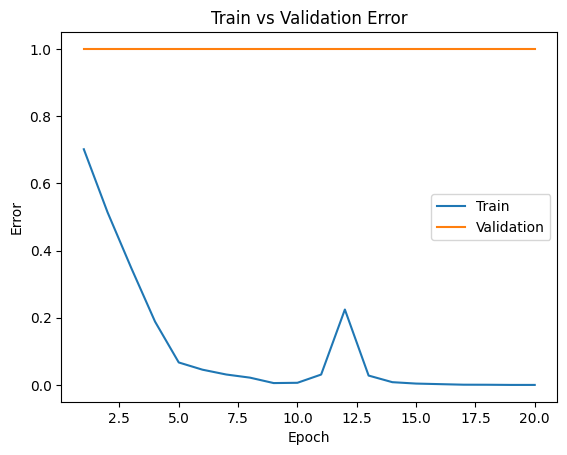

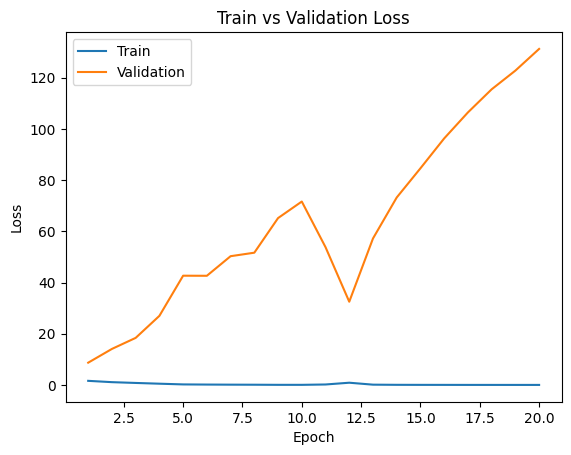

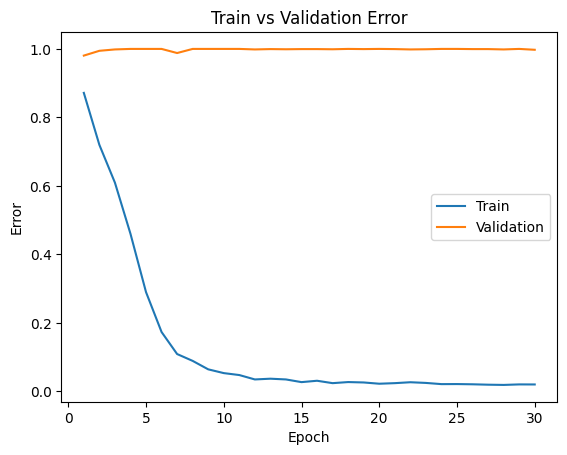

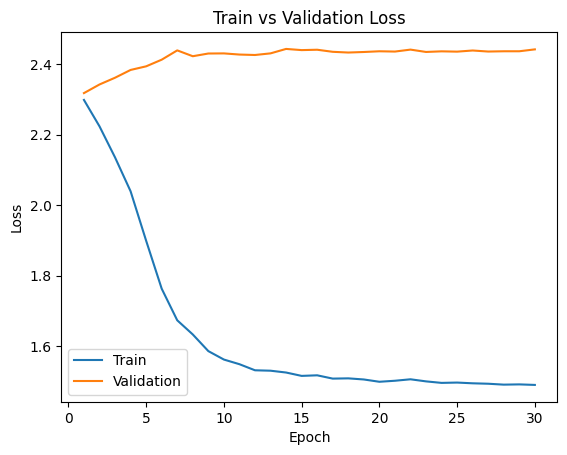

In [28]:
# Graphing
plot_training_curve("baseline_model")
plot_training_curve("primary_model")

Done Loading Data


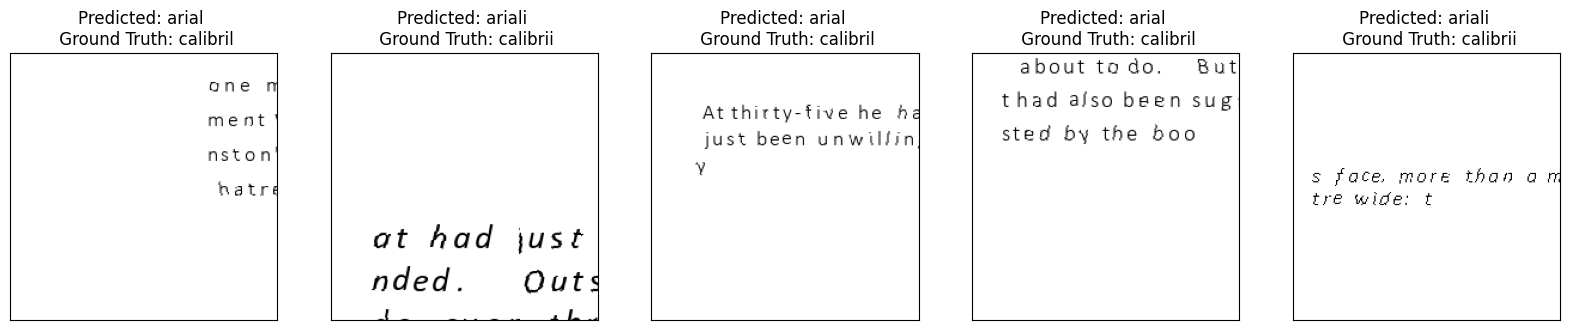

Done Loading Data


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [29]:
# Visualizing
visualize_output(5 ,"baseline_model\\best_model", BaselineModel)
visualize_output(5, "primary_model\\best_model", PrimaryModel, model_params = [auto_encoder.encoder, auto_encoder.decoder])

Done Loading Data


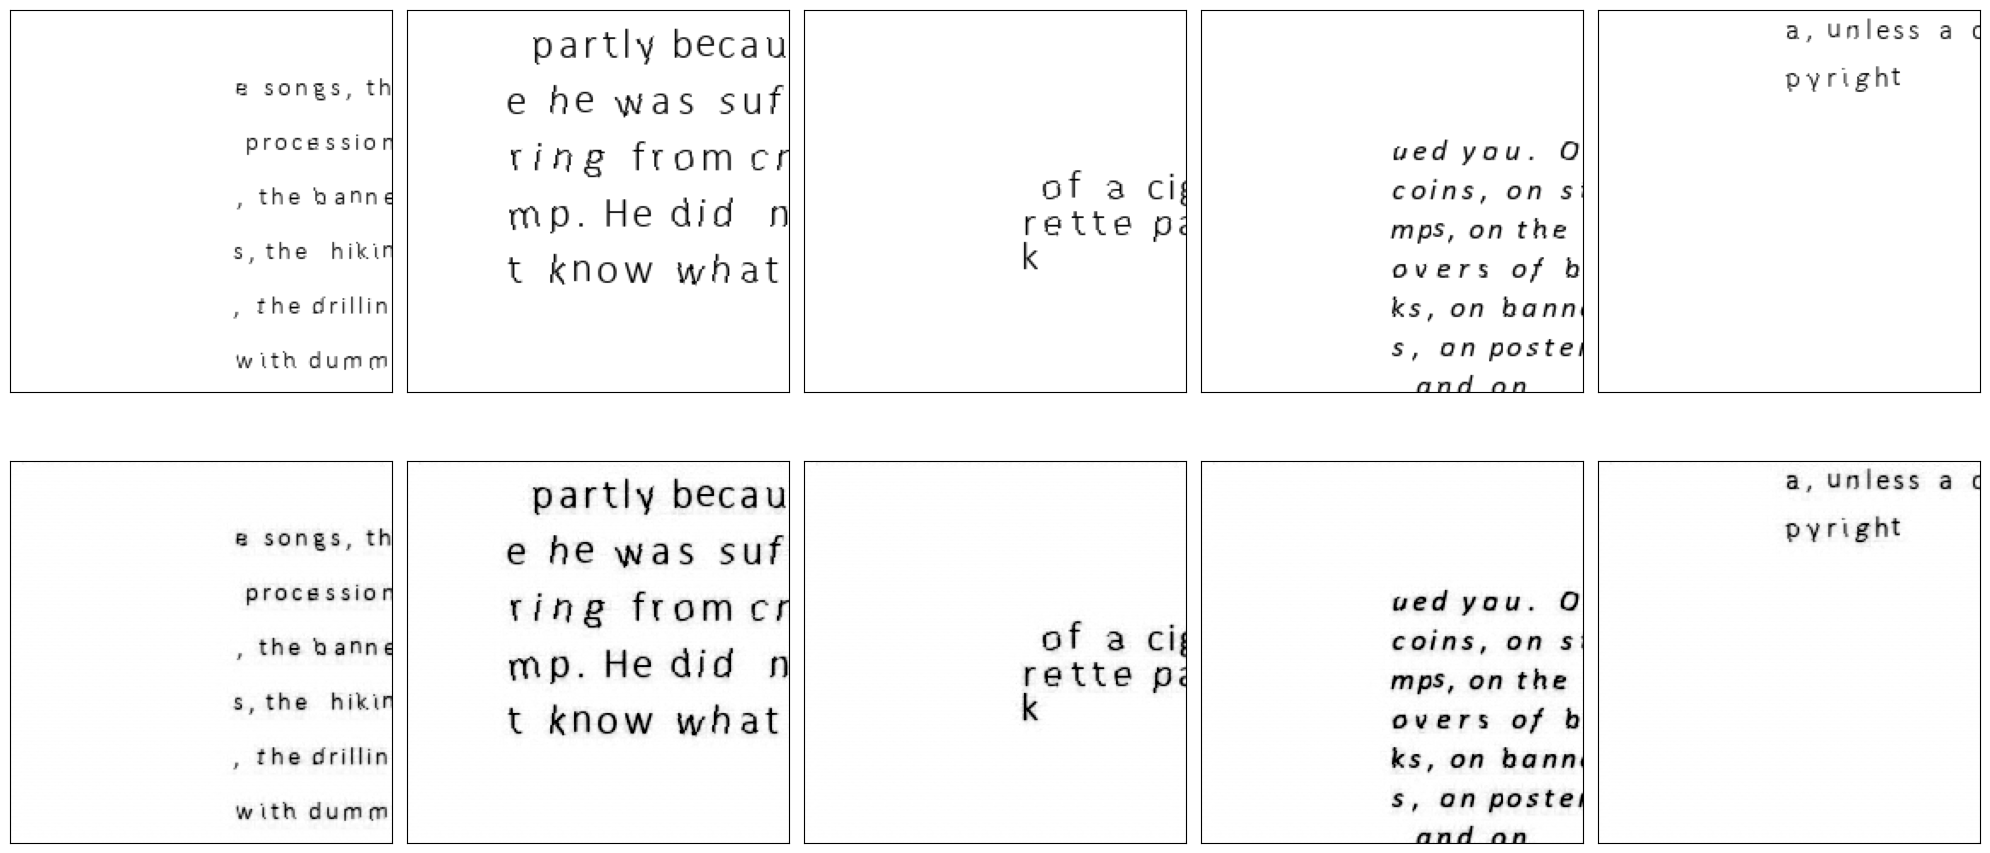

In [30]:
visualize_autoencoder_output(5, "autoencoder\\best_model", AutoEncoder)


Done Loading Data


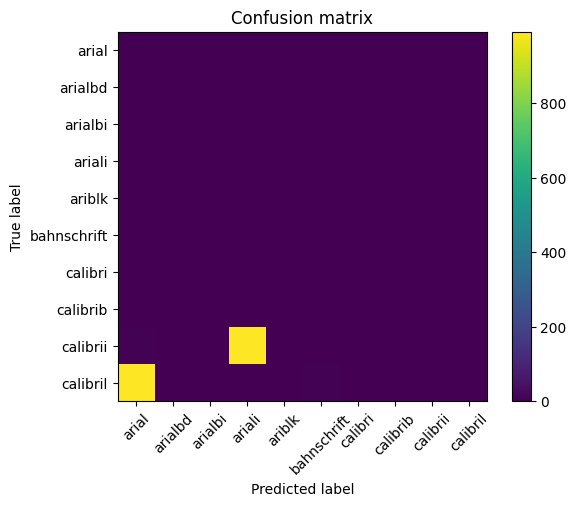

TypeError: generate_confusion_matrix() got an unexpected keyword argument 'model_params'

In [31]:
# Confusion Matrix
generate_confusion_matrix(BaselineModel, "baseline_model\\best_model")
generate_confusion_matrix(PrimaryModel, "primary_model\\best_model", model_params = [auto_encoder.encoder, auto_encoder.decoder])

In [33]:
class PrimaryModel2(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel2, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) #28x28
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(128, 64, 1) #28x28
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128, 64, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*28*28, 28*28)
        self.bn6 = nn.BatchNorm1d(28*28)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(28*28, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        
        x1 = self.decoder(self.encoder(x))        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = torch.cat((x1,x2), dim=1) #128x28x28
        x = self.bn5(F.relu(self.conv5(x))) #64x28x28
                
        x = x.view(-1, 64*28*28)
        x = self.bn6(self.dropout(F.relu(self.fc1(x))))
        x = self.bn7(self.dropout(F.relu(self.fc2(x))))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [37]:
auto_encoder = AutoEncoder()
auto_encoder.load_state_dict(torch.load("autoencoder\\best_model"))
train_net(PrimaryModel2, "primary_model2", [auto_encoder.encoder.to("cuda"), auto_encoder.decoder.to("cuda")], learning_rate=0.00005, batch_size=128, num_epochs=30)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.8826666666666667, Train loss: 2.300747663416761 | Validation err: 0.9995, Validation loss: 2.3160162419080734
Epoch 2: Train err: 0.7876666666666666, Train loss: 2.2669780558728156 | Validation err: 0.996, Validation loss: 2.317279353737831
Epoch 3: Train err: 0.6763333333333333, Train loss: 2.215697268222241 | Validation err: 0.9995, Validation loss: 2.321467250585556
Epoch 4: Train err: 0.5576666666666666, Train loss: 2.1612402124607817 | Validation err: 0.9995, Validation loss: 2.324718162417412
Epoch 5: Train err: 0.44033333333333335, Train loss: 2.1005692684904056 | Validation err: 1.0, Validation loss: 2.331352487206459
Epoch 6: Train err: 0.30983333333333335, Train loss: 2.03162005607118 | Validation err: 1.0, Validation loss: 2.3404615819454193
Epoch 7: Train err: 0.18566666666666667, Train loss: 1.9499163069623582 | Validation err: 1.0, Validation loss: 2.3411979228258133
Epoch 8: Train err: 0.11, Train loss: 1.86466833